In [53]:
import pandas as pd
pd.set_option('display.max_columns', None)  #显示全部列
pd.set_option('display.max_rows', None)    #显示全部行
import numpy as np
import os
import pymongo
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.metrics import mean_absolute_error as mae
from sklearn.feature_selection import RFECV
from matplotlib.ticker import MultipleLocator
from matplotlib.backends.backend_pdf import PdfPages
from sklearn.model_selection import cross_val_score,GridSearchCV
from utils import load_xy, ini_tree, ini_tree_choose, load_config, loc_zq_collection
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression,ElasticNet,Ridge,Lasso
from sklearn.feature_selection import RFE
from tscv import GapWalkForward
import warnings
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']  # 中文显示
plt.rcParams['axes.unicode_minus'] = False  # 负号显示
%matplotlib inline

import matplotlib.ticker as ticker
warnings.filterwarnings("ignore")

import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [45]:
X = pd.read_excel('x_sw_sysh.xlsx', index_col=0)
X = X.resample('M').last()
X.index = [i.strftime("%Y-%m-%d") for i in X.index]
Y = pd.read_excel('y_ppi.xlsx', index_col=0)['PPI:石油和天然气开采业:当月同比']
Y.index = [i.strftime("%Y-%m-%d") for i in Y.index]
x_data = X[:85]
y_data = Y[:85]
print('get the x_data and y_data!!!')

get the x_data and y_data!!!


In [20]:
x_data.columns

Index(['零售价:93#汽油(国IV):深圳', '出厂价:邻二甲苯:镇海炼化', '出厂价:煤制石脑油(组分柴油):陕西华航',
       '出厂价:渣油:东营东明化工', '出厂价:碳9(C9,裂解):齐鲁石化', '现货价(中间价):苯酐(熔融):美国海湾离岸',
       '市场价(现货基准价):PTA:华东', '出厂价:沥青(200#):中海滨州', '出厂价:煤油:山东淄博文奥经贸航空',
       '出厂价:邻二甲苯:吉林石化', '市场价(高端价):邻二甲苯:华东地区', '市场价(平均价):邻二甲苯:华东地区',
       '市场价(平均价):C5石油树脂(5#路标漆用):华东地区', '出厂价:碳5(C5,裂解):齐鲁石化',
       '出厂价:沥青(200#):宁波大榭', '出厂价:道路沥青(70#B级重交沥青):燕山石化(保定)',
       '市场价(中间价):精对苯二甲酸(PTA):华东地区', '最高零售价:汽油(标准品):天津', '出厂价:碳5(C5,精):山东鲁华',
       '出厂价:碳5(C5,裂解):抚顺石化', '出厂价:碳5(C5,精):濮阳瑞科', '出厂价:碳5(C5,裂解):燕山石化',
       '现货价(平均价):燃料油(进口高硫180CST):华南地区', '出厂价:油浆:正和炼厂', '市场价(中间价):甲苯:华东地区',
       '出厂价:液蜡(300#):锦西石化', '出厂价:芳烃溶剂油(100#):潍坊润海', '出厂价:乙烯焦油:天津中沙',
       '市场价(现货基准价):MTBE:全国', '市场价:液化气LPG:全国'],
      dtype='object')

In [24]:
dire = pd.DataFrame(index = x_data.columns)
dire.index.name = 'x'
dire.name = 'direction'

In [27]:
def direction(x):
    
    if x > 0:
        return 1
    elif x < 0:
        return -1
    else:
        return 0
    
def bo_corr(seri,y):
    return seri[seri * y >= 0].count()/len(seri)

def zero_count(x):
    return x[x == 0].count()

In [32]:
dire_list = [list(map(direction,list(x_data.iloc[i+1]-x_data.iloc[i]))) for i in range(x_data.shape[0]-1)]
dire_data = pd.DataFrame(dire_list,columns=x_data.columns)
y = [direction(y_data.iloc[i+1]-y_data.iloc[i]) for i in range(y_data.shape[0]-1)]
y_p = [direction(y_con.iloc[i+1]-y_con.iloc[i]) for i in range(y_con.shape[0]-1)]
# 没有第一期，注意索引数少1
zero_data = pd.Series([zero_count(dire_data.iloc[:,i]) for i in range(dire_data.shape[1])],index = dire_data.columns)

In [36]:
bo_data = [bo_corr(dire_data.iloc[:,i],y) for i in range(dire_data.shape[1])]
bo_data = pd.Series(bo_data, index = dire_data.columns)
score = pd.DataFrame(index = dire_data.columns)
score['bo_score'] = bo_data
score['zero_num'] = zero_data

In [47]:
score

,bo_score,zero_num
x,,
零售价:93#汽油(国IV):深圳,0.666667,0
出厂价:邻二甲苯:镇海炼化,0.630952,3
出厂价:煤制石脑油(组分柴油):陕西华航,0.904762,58
出厂价:渣油:东营东明化工,0.857143,56
"出厂价:碳9(C9,裂解):齐鲁石化",0.654762,2
现货价(中间价):苯酐(熔融):美国海湾离岸,0.714286,5
市场价(现货基准价):PTA:华东,0.547619,0
出厂价:沥青(200#):中海滨州,0.654762,3
出厂价:煤油:山东淄博文奥经贸航空,0.761905,20


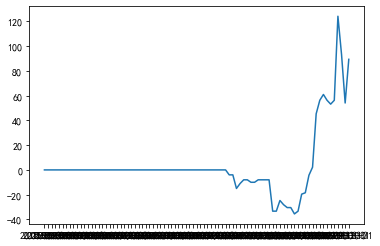

In [46]:
plt.plot(x_data['出厂价:煤制石脑油(组分柴油):陕西华航'])

In [48]:
x_data = x_data.drop(['出厂价:煤制石脑油(组分柴油):陕西华航'],axis =1)

In [50]:
x_data.shape

(85, 29)

In [81]:
#网格搜索
best_ting = {'alpha':[0.01,0.1,1,4,7,8,10,500]}
best_g = GridSearchCV(Lasso(),best_ting,cv=gcv)
best_g.fit(x_data,y_data)
print(best_g.best_params_)
print(best_g.best_score_)
print(best_g.best_index_)

{'alpha': 1}
-0.698298437692413
2


In [68]:
#3折时间序列交叉验证集
tscv = TimeSeriesSplit(n_splits=3,max_train_size=x_data.shape[0]-12)
gcv = GapWalkForward(n_splits=5,gap_size=2,test_size=6)


In [178]:
lre = LinearRegression() #线性回归模型
ela = ElasticNet(alpha = 10) #弹性网络模型
las = Lasso(alpha = 1) # Lasso
rid = Ridge(alpha =500)
method = [lre,ela,las,rid]
k=0
mae2 =[]
cmm =[[],[],[],[]]
for i in method:
    rfe = RFECV(estimator=i,step=1,cv=gcv).fit(x_data,y_data)
    k += 1
    sup = rfe.support_
    result = rfe.cv_results_
    col = x_data.columns[sup]
    x_new = x_data[col]
    cmm[k-1] = col
    # print(x_data.columns[sup])
    # print(x_new.head())
    print(rfe.estimator_)
    print(x_data[col].shape)
    mae1 = []
    for train,test in  gcv.split(range(x_new.shape[0])):
        x_train = x_new.iloc[train]
        x_test = x_new.iloc[test]
        y_train = y_data.iloc[train]
        y_test = y_data.iloc[test]
        for j in method:
            j.fit(x_train,y_train)
            y_pred = j.predict(x_test)
            mae1.append(mae(y_test,y_pred))
    mae2.append(np.mean(mae1))
print(mae2)
print(mae2.index(min(mae2)),min(mae2))

LinearRegression()
(85, 12)
ElasticNet(alpha=10)
(85, 7)
Lasso(alpha=1)
(85, 13)
Ridge(alpha=500)
(85, 14)
[9.826769198274961, 10.749176376992386, 9.35490994407154, 10.316621273028167]
2 9.35490994407154


                                     VIF
出厂价:邻二甲苯:镇海炼化                 371.546955
现货价(中间价):苯酐(熔融):美国海湾离岸          5.142977
出厂价:沥青(200#):中海滨州               9.057962
出厂价:煤油:山东淄博文奥经贸航空              10.768772
出厂价:邻二甲苯:吉林石化                 301.264026
市场价(高端价):邻二甲苯:华东地区             42.808774
市场价(平均价):邻二甲苯:华东地区             68.878906
出厂价:沥青(200#):宁波大榭              19.563234
出厂价:道路沥青(70#B级重交沥青):燕山石化(保定)    6.931712
市场价(中间价):甲苯:华东地区               19.398698
出厂价:芳烃溶剂油(100#):潍坊润海           23.768041
出厂价:乙烯焦油:天津中沙                   9.319933
mean:
 VIF    74.037499
dtype: float64
                                    VIF
出厂价:邻二甲苯:镇海炼化                  5.725707
现货价(中间价):苯酐(熔融):美国海湾离岸         4.372110
出厂价:沥青(200#):中海滨州             10.385961
市场价(平均价):C5石油树脂(5#路标漆用):华东地区   1.911689
出厂价:沥青(200#):宁波大榭             10.719853
出厂价:油浆:正和炼厂                   10.127957
出厂价:芳烃溶剂油(100#):潍坊润海          10.016337
mean:
 VIF    7.608516
dtype: float64
                                     VIF
零售价:93#汽油(国IV):深圳            

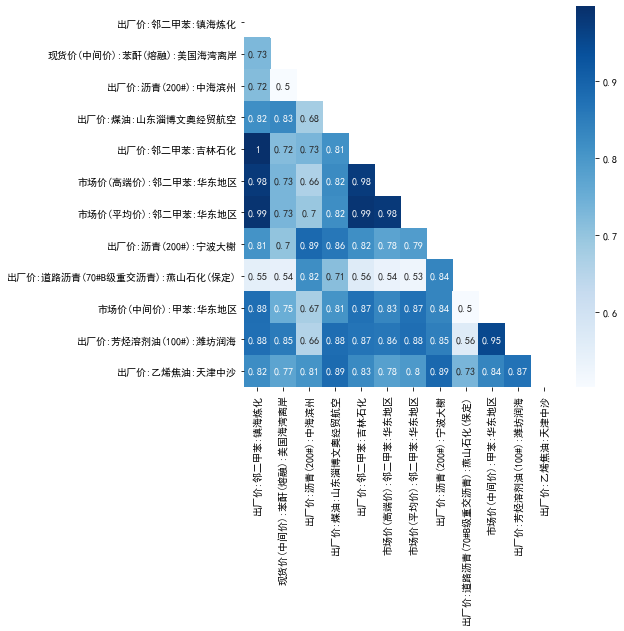

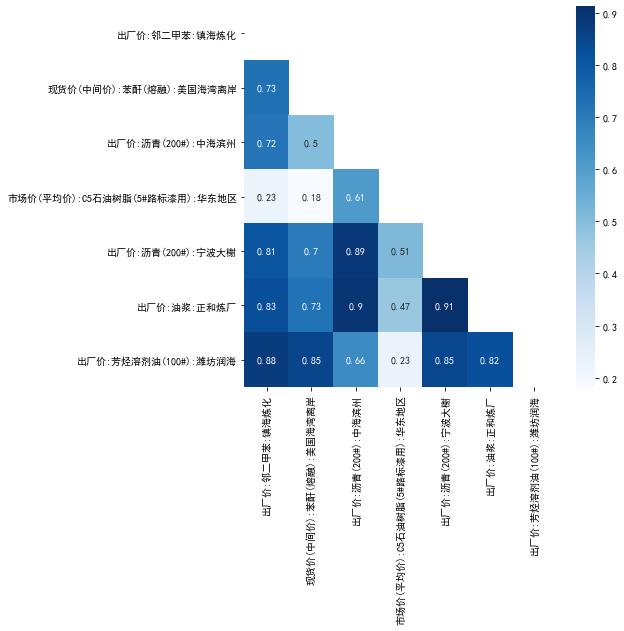

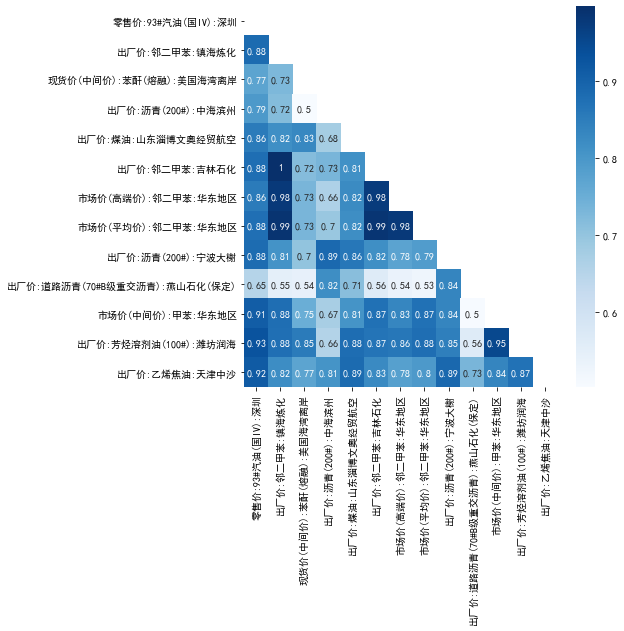

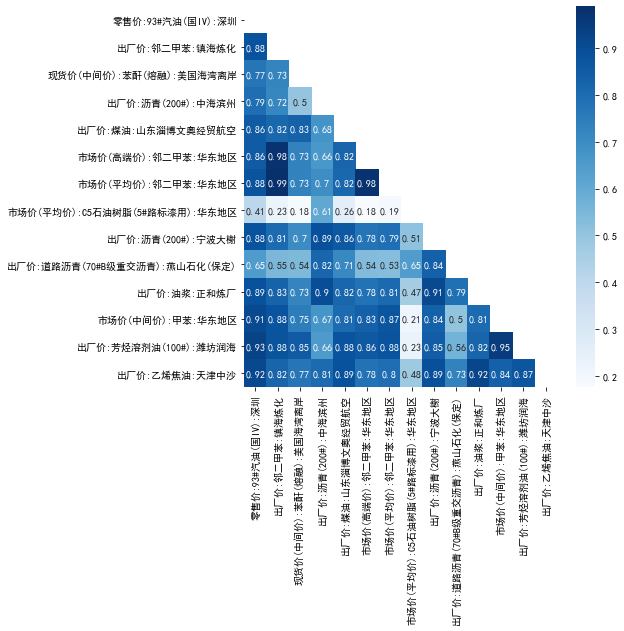

In [179]:
mean=[]
for i in range(len(mae2)):
    fig = plt.figure(figsize=(7,7))
    fig.title = method[i]
    feature = cmm[i]
    x_select = x_data[feature]
    cor = x_select.corr()
    mask = np.zeros_like(cor)
    mask[np.tril_indices_from(mask)] = True
    
    
    # x_select.to_excel('x_select1.0.xlsx',index=True)
    #     print(x_select.shape)
    vif = [variance_inflation_factor(x_select.values, x_select.columns.get_loc(i)) for i in x_select.columns]
    vif_table = pd.DataFrame(vif ,index = x_select.columns)
    vif_table.columns = ['VIF']
    print(vif_table)
    mean.append(np.mean(vif_table['VIF']))
    print('mean:\n',np.mean(vif_table))
#     print(list(zip(list(x_select.columns), vif)))
    if np.mean(vif_table['VIF']) < 100:
        sns_plot = sns.heatmap(cor, annot=True,cmap='Blues',mask = mask.T)
        

mae_vif = pd.DataFrame(mae2,index = method)
mae_vif['vif'] = mean
mae_vif.columns=(['mae','vif'])
mae_vif['score'] = mae_vif['mae']*0.5 + mae_vif['vif']*0.5

print(mae_vif)

In [106]:
mae_vif

,mae,vif,score
LinearRegression(),10.210058,74.037499,42.123779
ElasticNet(alpha=10),11.233550,7.608516,9.421033
Lasso(alpha=10),9.823859,1.336620,5.580240
Ridge(alpha=500),11.071048,27.293273,19.182161


In [160]:
min_ = 2
data = x_data[cmm[min_]]
# del data['出厂价:邻二甲苯:吉林石化']
model = method[min_].fit(x_train,y_train)
y_pre = model.predict(x_test)
y_pre = pd.Series(y_pre,index = y_test.index)
y_con = pd.concat([y_train,y_pre],axis=0)

In [165]:
y_data.shape

(85,)

85

0                零售价:93#汽油(国IV):深圳
1                    出厂价:邻二甲苯:镇海炼化
2           现货价(中间价):苯酐(熔融):美国海湾离岸
3                出厂价:沥青(200#):中海滨州
4                出厂价:煤油:山东淄博文奥经贸航空
5                    出厂价:邻二甲苯:吉林石化
6               市场价(高端价):邻二甲苯:华东地区
7               市场价(平均价):邻二甲苯:华东地区
8                出厂价:沥青(200#):宁波大榭
9     出厂价:道路沥青(70#B级重交沥青):燕山石化(保定)
10                市场价(中间价):甲苯:华东地区
11            出厂价:芳烃溶剂油(100#):潍坊润海
12                   出厂价:乙烯焦油:天津中沙
dtype: object 

mae       9.354910
vif      74.281900
score    41.818405
Name: Lasso(alpha=1), dtype: float64


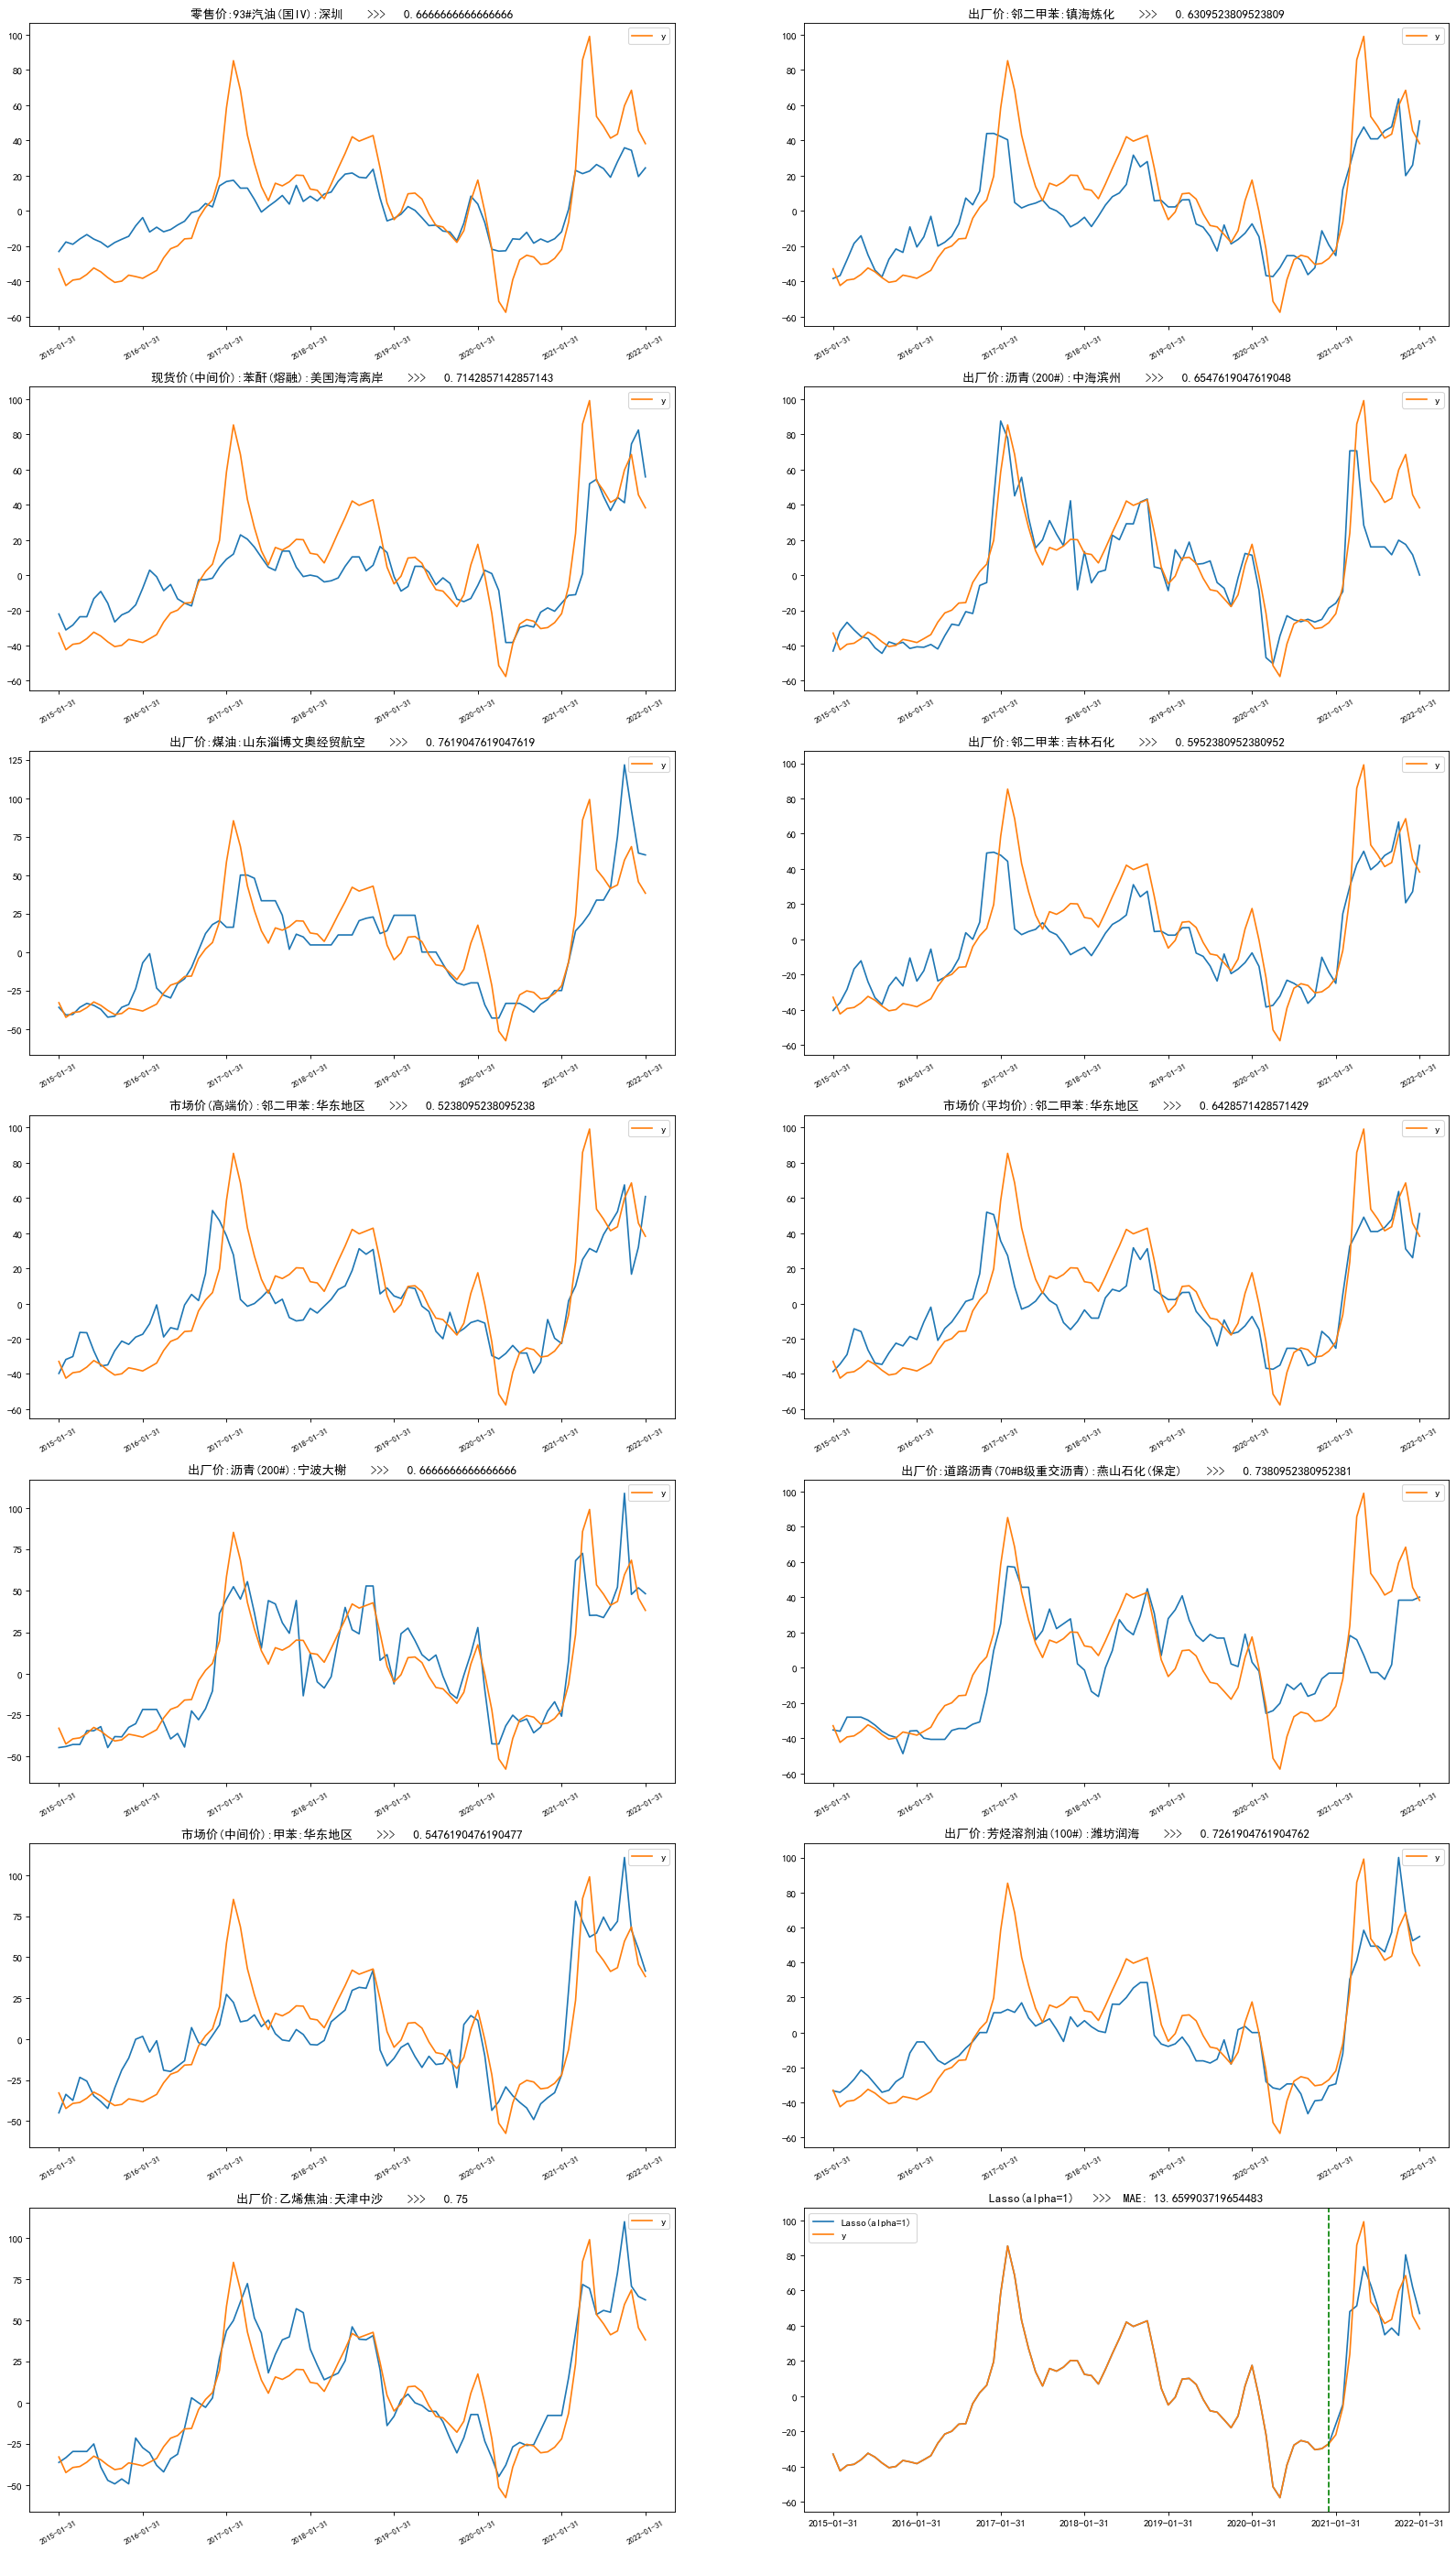

In [181]:
# min_ = int(np.where(mae_vif['score'] == np.min(mae_vif['score']))[0][0])
min_ = 2
data = x_data[cmm[min_]]
# del data['出厂价:邻二甲苯:吉林石化']
model = method[min_].fit(x_train,y_train)
y_pre = model.predict(x_test)
y_pre = pd.Series(y_pre,index = y_test.index)
y_con = pd.concat([y_train,y_pre],axis=0)

x_train = data.iloc[:72]
x_test = data.iloc[72:]
y_train = y_data[:72]
y_test = y_data[72:]
mae_ = mae(y_pre,y_test)

pre_bo = bo_corr(pd.Series(y_p),y)

fig = plt.figure(figsize=(25,45),dpi=80)
print(pd.Series(cmm[min_]),'\n')
print(mae_vif.iloc[min_,:])
for i in range(data.shape[1]+1):
    if i == data.shape[1]:
        
        ax= fig.add_subplot(7,2,i+1)
        ax.set_title(str(method[min_])+'   >>>  MAE: ' +str(mae_)  )
#         ax.tick_params(axis='x',labelsize=8, roation=30)
        ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
        
        ax.plot(y_data.index,y_con,label=method[min_])
        ax.plot(y_data.index,y_data,label = 'y')
        plt.axvline(x='2020-12-31',ls="--",c="green")
        plt.legend()
        
    else:
        tick_spacing = 12
        ax = fig.add_subplot(7,2,i+1)
        ax.set_title(cmm[min_][i] +'    >>>   '+ str(bo_data[cmm[min_][i]]))
    #     plt.subplots_adjust(left = 0.01,right=0.8,wspace=0.2)
        ax.tick_params(axis='x', labelsize=8, rotation=30)
        ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
#         ax.plot(y_data.index,y_data)

        # ax.plot(y_test)
        ax.plot(data.index,data.iloc[:,i])
        ax.plot(y_data.index,y_data,label='y')
        plt.legend()
    
plt.savefig('sy_feature'+str(method[min_])+'.pdf',format = 'pdf')
#     plt.title('II')